# ABS Quarterly Labour Account 6150

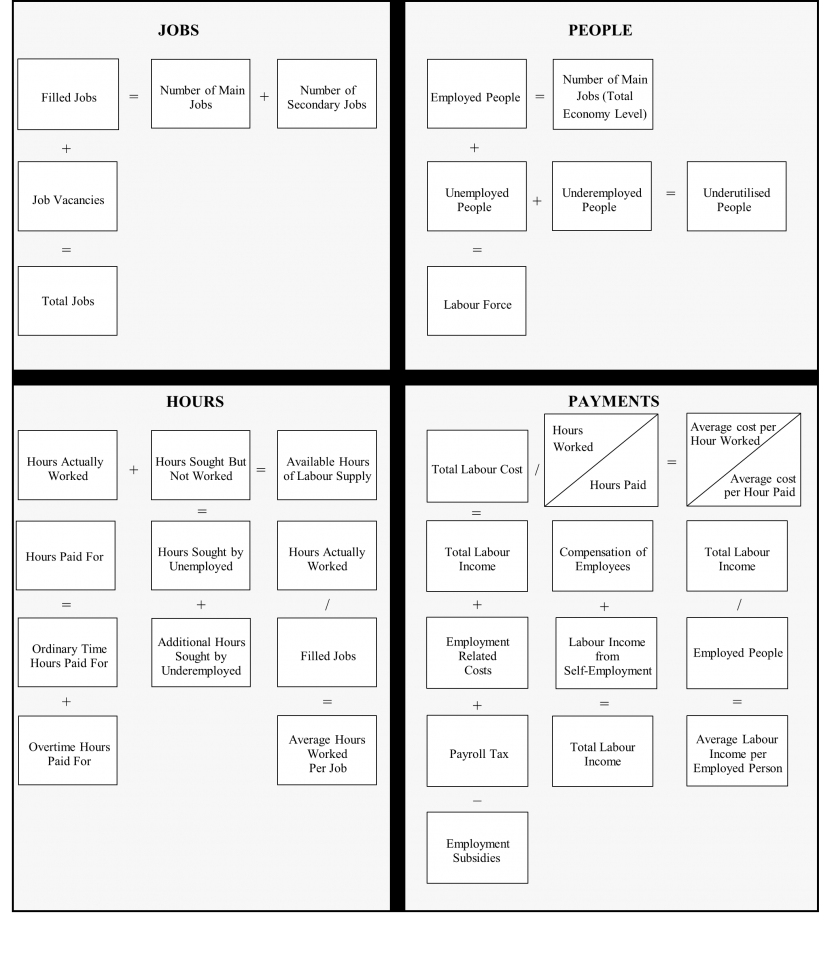

## Python set-up

In [1]:
# system imports
import textwrap

# analytic imports
import pandas as pd
import matplotlib.pyplot as plt
import readabs as ra
from readabs import metacol

In [2]:
# local imports
from abs_helper import get_abs_data
from abs_summary_plot import plot_summary
from plotting import (
    recalibrate_series,
    plot_covid_recovery,
    line_plot,
    plot_growth_finalise,
    calc_growth,
)

In [3]:
# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
SHOW = False

## Get data from ABS

In [4]:
labour_cat = "6150.0.55.003"
abs_dict, meta, source, RECENT = get_abs_data(labour_cat)
plot_times = None, RECENT
plot_tags = "", "-recent"

In [5]:
# list tables
textwrap.wrap(", ".join(abs_dict.keys()), width=80)

['Industry summary table, 6150055003DO001, 6150055003DO002, 6150055003DO003,',
 '6150055003DO004, 6150055003DO005, 6150055003DO006, 6150055003DO007,',
 '6150055003DO008, 6150055003DO009, 6150055003DO010, 6150055003DO011,',
 '6150055003DO012, 6150055003DO013, 6150055003DO014, 6150055003DO015,',
 '6150055003DO016, 6150055003DO017, 6150055003DO018, 6150055003DO019,',
 '6150055003DO020, 6150055003DO021, 6150055003DO022']

## Plot

### Exploratory

In [6]:
# check the identity: Filled jobs + Job vacancies = Total jobs
stems = [
"Jobs; Filled jobs ;  Australia ;  Total all industries ;",
"Jobs; Job vacancies ;  Australia ;  Total all industries ;",
"Jobs; Total jobs ;  Australia ;  Total all industries ;",
]
data_dict = {}
table = 'Industry summary table'
for stem in stems:
    sid = meta.loc[ (meta[metacol.table] == table)  & (meta[metacol.did] == stem), metacol.id].values[0]
    key = stem.split(";")[1].strip()
    data_dict[key] = abs_dict[table][sid]
sum_check = data_dict['Filled jobs'] + data_dict['Job vacancies'] - data_dict['Total jobs']
(sum_check.abs() > 0.0001).sum()
    

0

#### Compare Job Vacacnies in the Labour Account with elsewhere.

In [7]:
# Seasonally adjusted data from the ABS Job Vacancies series
jv_cat, jv_id, jv_seo = "6354.0", "A590698F", "6354001"
jv_frame, jv_meta = ra.read_abs_series(jv_cat, jv_id, single_excel_only=jv_seo)
jv_series = jv_frame[jv_id]
index = pd.PeriodIndex(jv_series.index.to_timestamp(how="end"), freq="Q-DEC")
jv_series.index = index

# Seasonally adjusted data from the ABS Labour Account
table = 'Industry summary table'
did = "Jobs; Job vacancies ;  Australia ;  Total all industries ;"
la_id = meta.loc[(meta[metacol.table] == table) & (meta[metacol.did] == did), metacol.id ].values[0]
la_series = abs_dict[table][la_id]

# combine
frame = pd.DataFrame({"Job Vacancies Survey": jv_series, "Labour Account": la_series})
line_plot(
    frame, 
    title="ABS Job Vacancies Survey v Labour Account", 
    ylabel="Job Vacancies, Thousands", 
    starts=plot_times,
    rfooter=f"{source} {jv_cat}",
    lfooter="Australia. Seasonally adjusted. "
    +"Note: ABS Job Vacancies Survey data mapped from quarter ending Nov to quarter ending Dec.",
    width=2,
    show=SHOW,
)

#### Employed persons

In [8]:
lfs_cat = "6202.0"
emp_sa_id = "A84423043C"
emp_sa = ra.read_abs_series(lfs_cat, emp_sa_id, single_excel_only="6202001")
emp_sa_q = ra.monthly_to_qtly(emp_sa[0][emp_sa_id], f="mean")
emp_sa_q.name = (
    emp_sa[1][metacol.did].values[0] 
    + " (Labour Force Survey, quarterly mean)"
)

table = "6150055003DO001"
stems = [
    "Jobs; Filled jobs ;  Australia ;  Total all industries ;",
    "Persons; Labour Account employed persons ;  Australia ;  Total all industries ;",
    "Persons; Labour Account main job holders ;  Australia ;  Total all industries ;",
]
data = abs_dict[table]
sid = meta[ 
    (meta[metacol.table] == table) 
    & (meta[metacol.did].isin(stems))
    & (meta[metacol.stype] == "Seasonally Adjusted")
    & (meta[metacol.unit] == "000")][metacol.id]
names = {k: meta[meta[metacol.id] == k][metacol.did].values[0] for k in sid}
plot = pd.concat([abs_dict[table][sid].rename(columns=names), emp_sa_q], axis=1).sort_index()
plot, units = ra.recalibrate(plot, "Thousands")
line_plot(
    plot, 
    title="Filled Jobs v Employed Persons", 
    ylabel=units, 
    starts=plot_times,
    rfooter=f"{source} {lfs_cat}",
    lfooter="Australia. Seasonally adjusted. ",
    width=1.5,
    show=SHOW,
)

#### Labour Force - LFS vs LA

In [9]:
lfs_cat = "6202.0"
lf_sa_id = "A84423047L"
lf_sa = ra.read_abs_series(lfs_cat, lf_sa_id, single_excel_only="6202001")
lf_sa_q = ra.monthly_to_qtly(lf_sa[0][lf_sa_id], f="mean")
lf_sa_q.name = (
    lf_sa[1][metacol.did].values[0] 
    + " (Labour Force Survey, quarterly mean)"
)

table = "6150055003DO001"
stems = [
    "Persons; Labour Account labour force ;  Australia ;  Total all industries ;",
]
data = abs_dict[table]
sid = meta[ 
    (meta[metacol.table] == table) 
    & (meta[metacol.did].isin(stems))
    & (meta[metacol.stype] == "Seasonally Adjusted")
    & (meta[metacol.unit] == "000")][metacol.id]
names = {k: meta[meta[metacol.id] == k][metacol.did].values[0] for k in sid}
plot = pd.concat([abs_dict[table][sid].rename(columns=names), emp_sa_q], axis=1).sort_index()
plot, units = ra.recalibrate(plot, "Thousands")
line_plot(
    plot, 
    title="Labour Force - Labour Account v Labour Force Survey", 
    ylabel=units, 
    starts=plot_times,
    rfooter=f"{source} {lfs_cat}",
    lfooter="Australia. Seasonally adjusted. ",
    width=1.5,
    show=SHOW,
)

### Summary plots

In [10]:
def summary_plot() -> None:

    table = 'Industry summary table'
    data = abs_dict[table]

    stems = [
        #(title, search_term)
        ("# Total Jobs", "Jobs; Total jobs ;  Australia ;"),
        ("# Job Vacancies", "Jobs; Job vacancies ;  Australia ;"),
        ("# Filled Jobs", "Jobs; Filled jobs ;  Australia ;"),
        ("# Hours worked", "Volume; Labour Account hours actually worked in all jobs ;"),
    ]

    for title, search_term in stems:
        search = {
            table: metacol.table,
            search_term: metacol.did,
        }
        found = ra.search_meta(meta, search)
    
        # TO DO: bar chart latest

        # Summary plot
        labels = found[metacol.did].str.rsplit(pat=" ;  ", n=1).str[-1].str.replace(" ;", "")
        series_ids = labels.index
        required = {k: [v, 1] for k, v in zip(labels, series_ids)}
        plot_summary(
            required,
            abs_dict,
            meta,
            start="2000Q1",
            title=f"Q/Q Growth {title} {data.index[-1]}",
            rfooter=source,
            lfooter=f"Australia. Seasonally adjusted series. "
            + "All data is Q/Q percentage growth. ",
            show=SHOW,
        )


summary_plot()

Overriding x0: True
Overriding x0: True
Overriding x0: True
Overriding x0: True


### Labour productivity - GDP per hour worked ...

In [11]:
# GDP ...
gdp_cat = "5206.0"
gdp_data, gdp_meta = ra.read_abs_series(
    cat=gdp_cat, 
    series_id=["A2304402X", "A2304404C"],  # GDP, GDP per capita, CVM, SeasAdj
    single_excel_only="5206001_Key_Aggregates"
)
gdp = gdp_data["A2304402X"] * 1_000_000  # GDP 

# Hours worked ...
labour_table = "6150055003DO001"
series_type = "Seasonally Adjusted"
did = "Volume; Labour Account hours actually worked in all jobs ;  Australia ;  Total all industries ;"
search = {labour_table: metacol.table, did: metacol.did, series_type: metacol.stype}
_table, hours_id, units = ra.find_id(meta, search)
hours = abs_dict[labour_table][hours_id] * 1_000  # hours worked

# calculate productivity and plot
productivity = gdp / hours
ax = productivity.dropna().plot(lw=2.5)
title = "Labour Productivity: GDP per Hour Worked"
lfooter = (
    f"Australia. {series_type.capitalize()}. GDP: Chain volume measures. "
    "Hours: Total actual hours worked. "
)
rfooter = f"ABS: {gdp_cat} {labour_cat}"
units = "$"

line_plot(
    productivity,
    dropna=True,
    title=title,
    ylabel=units,
    rfooter=rfooter,
    lfooter=lfooter,
    show=SHOW,
)

growth = calc_growth(productivity)
plot_growth_finalise(
    *growth,
    title=f"Growth in {title}",
    rfooter=rfooter,
    lfooter=lfooter,
    show=SHOW,
)

### Headline

In [12]:
series_type = "Seasonally Adjusted"
not_unit = "Percent"
table = "6150055003DO001"
data = abs_dict[table]

rows = meta[
    (meta[metacol.table] == table)
    & (meta[metacol.stype] == series_type)
    & (meta[metacol.unit] != not_unit)
]

for index, row in rows.iterrows():
    series_id, units, title = row[metacol.id], row[metacol.unit], row[metacol.did]
    plotable, units = ra.recalibrate(data[series_id], units)
    plotable.name = f"{series_type.capitalize()} series"

    plot_covid_recovery(
        plotable,
        title=(
            title.replace(" ;  Australia ;  Total all industries ;", "")
            .replace(" per Labour Account", "\nper Labour Account")
            .replace(" ; ", " - ")
            .replace("; ", ": ")
        ),
        tags="covid",
        ylabel=units,
        start_r="2009Q4",
        end_r="2019Q4",
        rfooter=f"{source} T{table}",
        lfooter="Australia. All industries. ",
        show=SHOW,
    )

## Finished

In [13]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Fri Jul 12 2024 13:55:37

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

pandas    : 2.2.2
matplotlib: 3.9.1
readabs   : 0.0.8a2

Watermark: 2.4.3



In [14]:
print("Finished")

Finished
